# Lidar Data Example

This notebook demonstrates how to load, visualize, and manipulate Lidar data using the `fomo_sdk`.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
from pathlib import Path
from fomo_sdk.lidar.utils import load_fomo_lidar, make_top_view, save, transform_points
from fomo_sdk.tf.utils import FoMoTFTree

## 1. Load Raw Data (.bin)

We will load a binary lidar file. The format is expected to be `x, y, z, intensity, ring, timestamp`.

In [2]:
dataset_base_path = "data"
deployment = "2025-10-14"
trajectory = "red"

data = load_fomo_lidar(dataset_base_path, deployment, trajectory, load_robosense=True)

print(f"Loaded {len(data)} points")
print(f"Data shape: {data.shape}")
print("First 5 points:")
print(data[:5])

Loaded 169983 points
Data shape: (169983, 6)
First 5 points:
          x         y         z     i     r             t
0  0.548659 -0.065074 -0.108948   1.0   4.0  1.760456e+15
1  0.550051 -0.052168 -0.150771   1.0   2.0  1.760456e+15
2  0.513649  0.035366 -0.117401   1.0   3.0  1.760456e+15
3  0.822333 -0.101136 -0.091129  64.0  12.0  1.760456e+15
4  0.789278 -0.007492 -0.083814  64.0  14.0  1.760456e+15


## 2. Visualization

We can create a top-down view of the point cloud.

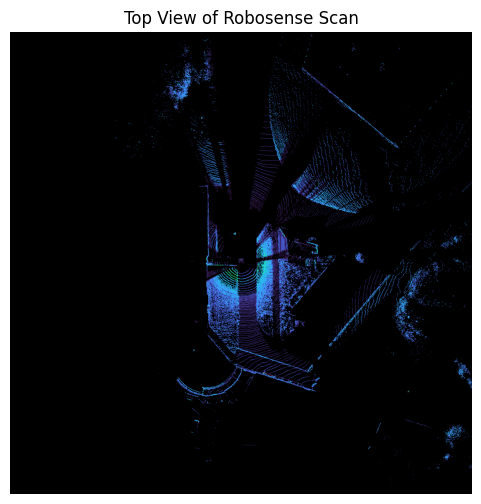

In [3]:
# Create top view image
# Adjust ranges based on your data
img = make_top_view(
    data,
    res=0.1,
    side_range=(-50, 50),
    fwd_range=(-50, 50),
    global_min_i=0.0,
    global_max_i=255.0,
)

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Top View of Robosense Scan")
plt.axis("off")
plt.show()

## 3. Add other lidar data

We can add data from the Leishen lidar to the visualization above.

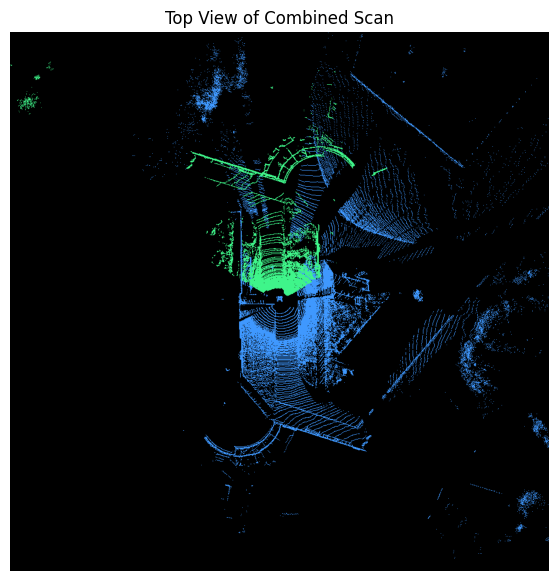

In [4]:
## TODO fix the TF
## TODO load scan that's the closest to the robosense scan
data_leishen = load_fomo_lidar(
    dataset_base_path, deployment, trajectory, load_robosense=False
)

# transform leishen to robosense frame
tf_tree = FoMoTFTree()
tf = tf_tree.get_transform(from_frame="leishen", to_frame="robosense")
data_leishen = transform_points(data_leishen, tf)

data["i"] = 50
data_leishen["i"] = 100
data_combined = pd.concat([data, data_leishen], ignore_index=True)

img = make_top_view(
    data_combined,
    res=0.1,
    side_range=(-50, 50),
    fwd_range=(-50, 50),
    global_min_i=0.0,
    global_max_i=255.0,
)

plt.figure(figsize=(7, 7))
plt.imshow(img)
plt.title("Top View of Combined Scan")
plt.axis("off")
plt.show()

## 4. Convert between CSV and BIN

We store lidar data in .bin for storage reasons. 

In [5]:
from fomo_sdk.lidar.utils import load

csv_file = Path("data/lidar.csv")

save(csv_file, data)
data_csv = load(csv_file)

print(f"Loaded {len(data_csv)} points")
print(f"Data shape: {data_csv.shape}")
print("First 5 points:")
print(data_csv[:5])

Loaded 169983 points
Data shape: (169983, 6)
First 5 points:
          x         y         z   i     r             t
0  0.548659 -0.065074 -0.108948  50   4.0  1.760456e+15
1  0.550051 -0.052168 -0.150771  50   2.0  1.760456e+15
2  0.513649  0.035366 -0.117401  50   3.0  1.760456e+15
3  0.822333 -0.101136 -0.091129  50  12.0  1.760456e+15
4  0.789278 -0.007492 -0.083814  50  14.0  1.760456e+15


## 5. Loading from Rosbag (TODO)

If you have a rosbag, you can use `rosbags` to read `sensor_msgs/PointCloud2`.
Note: This requires a valid rosbag file.

In [ ]:
# Example code for loading from rosbag
# from rosbags.rosbag2 import Reader
# from rosbags.serde import deserialize_cdr, ros1_to_cdr
# from fomo_sdk.lidar.utils import downsample_pointcloud

# bag_path = "path/to/your/rosbag"
# if os.path.exists(bag_path):
#     with Reader(bag_path) as reader:
#         for connection, timestamp, rawdata in reader.messages():
#             if connection.topic == "/your/lidar/topic":
#                 msg = deserialize_cdr(rawdata, connection.msgtype)
#                 # Process msg here
#                 print(f"Found message at {timestamp}")
#                 break